In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import re

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import logging
logging.basicConfig(level=logging.ERROR)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        return df
    except:
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

train_df = load_data('train', columns='full')
valid_df = load_data('valid', columns='full')
answer_df = load_data('test', columns='full')
answer_df['stars'] = 0 # create column for saving result later!!!

Text(0.5, 0, 'stars')

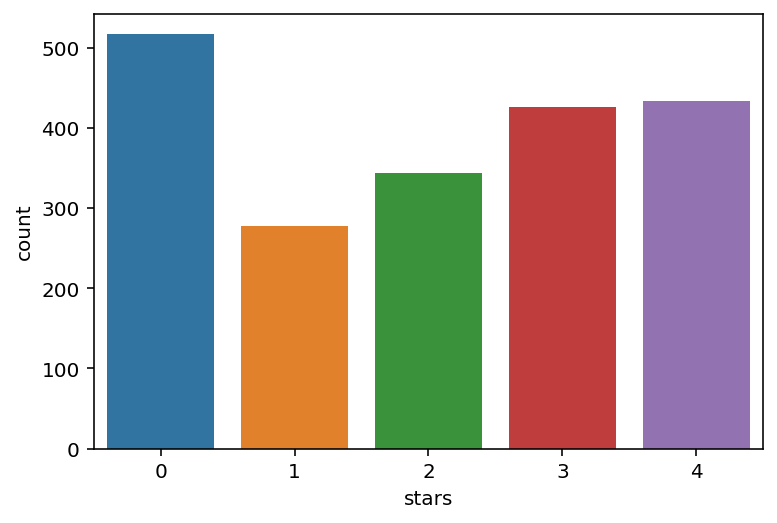

In [4]:
def to_sentiment(rating):
    rating = int(rating)
    if rating == 1:
        return 0
    elif rating == 2:
        return 1
    elif rating == 3:
        return 2
    elif rating == 4:
        return 3
    else:
        return 4
train_df['stars'] = train_df.stars.apply(to_sentiment)
valid_df['stars'] = valid_df.stars.apply(to_sentiment)


sns.countplot(valid_df.stars)
plt.xlabel('stars')

In [5]:
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text
 
train_df['text'] = train_df['text'].apply(clean_text)
valid_df['text'] = valid_df['text'].apply(clean_text)
answer_df['text'] = answer_df['text'].apply(clean_text)

In [6]:
class_names = ['0', '1','2','3','4']

In [7]:
train_df.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')

# XLNET

In [8]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,truncation=True)

## Checking the distribution of token lengths

In [9]:
token_lens = []
token_lens_valid_df = []


for txt in train_df['text']:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))
    
for txt in valid_df['text']:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens_valid_df.append(len(tokens))

Text(0.5, 0, 'Token count')

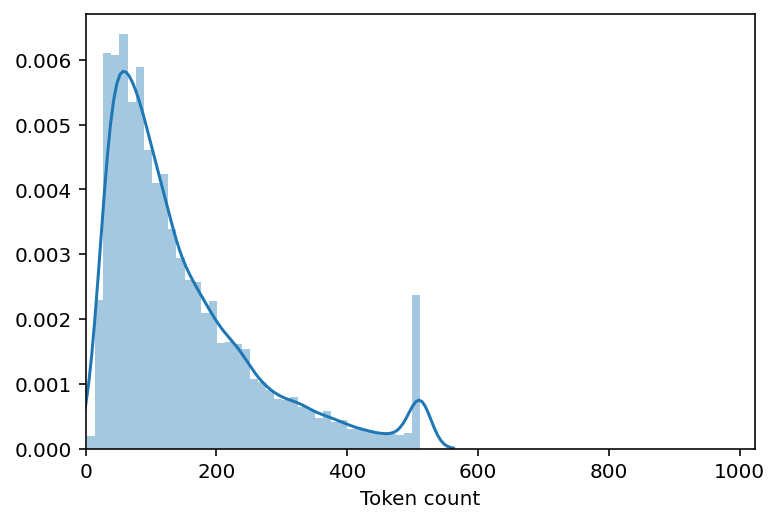

In [10]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count')

Text(0.5, 0, 'Token count')

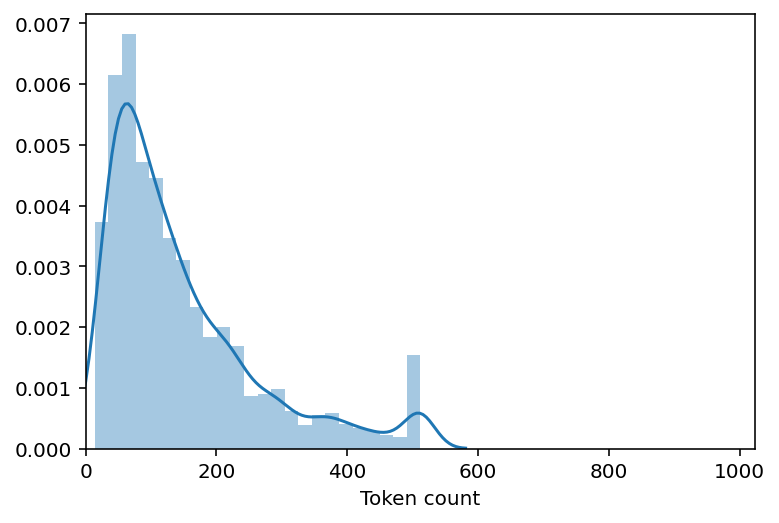

In [11]:
sns.distplot(token_lens_valid_df)
plt.xlim([0, 1024]);
plt.xlabel('Token count')

In [12]:
MAX_LEN = 512 

In [13]:
class predictdataset(Dataset):

    def __init__(self, texts, stars, tokenizer, max_len):
        self.texts = texts
        self.stars = stars
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        stars = self.stars[item]

        encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'text': text,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'stars': torch.tensor(stars, dtype=torch.long)
        }

In [14]:
df_train, df_val = train_test_split(train_df, test_size=0.1, random_state=101)
df_test = valid_df

In [15]:
df_train.shape, df_val.shape, df_test.shape

((9000, 9), (1000, 9), (2000, 9))

## Custom Dataloader

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = predictdataset(
    texts=df.text.to_numpy(),
    stars=df.stars.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [17]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
ans_data_loader = create_data_loader(answer_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 5)
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [19]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [20]:
EPOCHS = 4

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [21]:
data = next(iter(val_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['text', 'input_ids', 'attention_mask', 'stars'])

In [22]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
stars = data['stars'].to(device)
print(input_ids.reshape(EPOCHS,MAX_LEN).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [23]:
input_ids[0]

tensor([[   35,    26,    98,   885,    70,    24,   159,     9,   217,  1795,
          4427,   193,    57,    36,    30,  3382,    50,    24,   198,  1795,
            79,  7476,   733,     9,  1300,    21,   885,    18,   127, 14844,
           188,    75,   120,   733,    30,    18,   817,  2035,    38,    18,
          4081,    43,    54,    24,  1363,  5413,   662,    59,    35,   197,
           106,    86,   104,    77,  2784,     9,    69,    30,   573,    21,
            17,    23, 19860,  4546,    21,   675,   110,    65,  1139,  4666,
           115,   222,    24,  2251,    78,    35,    26,   189,    50,    72,
           193,   134,     9,    35,  1996,    18,   198,  6776,    33,   116,
          5891, 27884,   125, 10940,     9,    84,    30,  2882,    22,    39,
           900,    33,  7196, 13176,    57,  1129,   301,    33,  1919, 13176,
            59,    35,   112,    50,   115,    17,     9,   169,   345,   182,
            78,   102,    35,   314,    26,    46,  

In [24]:
outputs = model(input_ids.reshape(EPOCHS,MAX_LEN), token_type_ids=None, attention_mask=attention_mask, labels=stars)
outputs

XLNetForSequenceClassificationOutput(loss=tensor(1.6165, grad_fn=<NllLossBackward>), logits=tensor([[ 0.4312, -0.3149,  0.7090, -0.1863, -0.4255],
        [ 0.1993, -0.0656,  0.7310, -0.2060, -0.2625],
        [ 0.2810, -0.1323,  0.7393, -0.3661, -0.5053],
        [ 0.3765, -0.1147,  0.7326, -0.2975, -0.3842]],
       grad_fn=<AddmmBackward>), mems=(tensor([[[ 0.0257,  0.0011, -0.0448,  ..., -0.0297,  0.0106, -0.0088],
         [-0.0356, -0.0401, -0.0318,  ...,  0.0551,  0.0595, -0.0295],
         [ 0.0260, -0.0055, -0.0362,  ..., -0.0377,  0.0107, -0.0200],
         [ 0.0415, -0.0492, -0.0154,  ..., -0.0751, -0.0746, -0.0578]],

        [[-0.0564, -0.0022, -0.0290,  ...,  0.0329,  0.0430, -0.0191],
         [-0.0333,  0.0014,  0.0616,  ...,  0.0577,  0.0254,  0.0395],
         [ 0.1157, -0.0380,  0.0700,  ..., -0.0054,  0.0135,  0.0299],
         [ 0.0257,  0.0011, -0.0448,  ..., -0.0297,  0.0106, -0.0088]],

        [[ 0.0104,  0.0215, -0.0189,  ..., -0.0302,  0.0274, -0.0024],
     

In [25]:
type(outputs[0])

torch.Tensor

In [26]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(EPOCHS,MAX_LEN).to(device)
        attention_mask = d["attention_mask"].to(device)
        stars = d["stars"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = stars)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        stars = stars.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(stars, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [27]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(EPOCHS,MAX_LEN).to(device)
            attention_mask = d["attention_mask"].to(device)
            stars = d["stars"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = stars)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            stars = stars.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(stars, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [35]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'XLNET_model2e-5_new.bin')
        best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.9698280323959059 Train accuracy 0.5975555555555555
Val loss 0.8739239190220833 Val accuracy 0.65

Epoch 2/4
----------
Train loss 0.7376416669968102 Train accuracy 0.7218888888888889
Val loss 1.0547477351129055 Val accuracy 0.666

Epoch 3/4
----------
Train loss 0.6248155631510954 Train accuracy 0.8176666666666667
Val loss 1.5289753142055125 Val accuracy 0.67

Epoch 4/4
----------
Train loss 0.488507239067927 Train accuracy 0.8794444444444445
Val loss 1.6681856202271301 Val accuracy 0.693

CPU times: user 1h 7min 30s, sys: 1h 4min, total: 2h 11min 30s
Wall time: 2h 11min 28s


In [28]:
model.load_state_dict(torch.load('XLNET_model2e-5_new.bin',map_location=torch.device('cpu')))

<All keys matched successfully>

In [29]:
model = model.to(device)

In [30]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.6805
Test Loss : 1.763638732864638


In [31]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["text"]
            input_ids = d["input_ids"].reshape(BATCH_SIZE,MAX_LEN).to(device)
            attention_mask = d["attention_mask"].to(device)
            stars = d["stars"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = stars)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(stars)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values

In [32]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [33]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       517
           1       0.49      0.47      0.48       278
           2       0.56      0.54      0.55       344
           3       0.63      0.61      0.62       427
           4       0.76      0.80      0.78       434

    accuracy                           0.68      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.68      0.68      0.68      2000



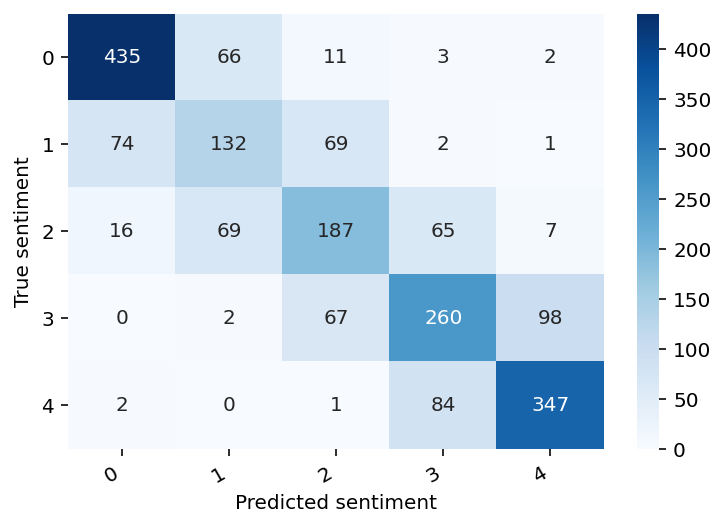

In [34]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

###  The best XLNET model is
###  Epoch:4, Batch Size:, Learning Rate: 2e-5, Dropping Rate: 0.3, maximum sequence length: 512, optimizer: 'AdamW'
### The accuracy is 0.6805

### Prediction

In [35]:
model.load_state_dict(torch.load('XLNET_model2e-5_new.bin',map_location=torch.device('cpu')))

<All keys matched successfully>

In [36]:
model = model.to(device)

In [37]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  ans_data_loader
)

In [38]:
answer_df['stars'] = y_pred+1
answer_df['pred_probs'] = y_pred_probs



In [41]:
preddf = answer_df[['review_id','stars']]

In [42]:
preddf.to_csv('pred.csv', index=False)